In [179]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from torch import nn,optim
import torch

import algo
import json
import scripts

import numpy as np
import pandas as pd

import attack
import random

import matplotlib.pyplot as plt


In [12]:
class Net_attack(nn.Module):

    def __init__(self, h_neurons, do, input_size):
        super(Net_attack, self).__init__()
        self.input_size = input_size
        self.h_neurons = h_neurons
        self.do = do
        self.fc1 = nn.Linear(input_size, h_neurons)
        self.fc2 = nn.Linear(h_neurons, 2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(do)
        self.softmax = nn.Softmax(dim=1)   

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = self.softmax(x)
        return x

class Train_args():

    def __init__(self, learning_rate, weight_decay, epoch):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epoch = epoch
         
def train_attack_model(model, train_data, train_target, train_args):

    optimizer = optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)
    
    model.train()
    optimizer.zero_grad()
    output = model(train_data)
    loss = nn.CrossEntropyLoss()(output, train_target.to(torch.long))
    loss.backward(retain_graph=True)
    optimizer.step()

    return model

def attack_evaluation(model, x, y, dev="cpu", extended=False):

    model.eval()

    with torch.no_grad():
        output =  model(x)
        out_target = output.argmax(1, keepdim=True)
        correct = out_target.to(dev).eq(y.to(dev).view_as(out_target.to(dev))).sum().item()
        acc = correct/y.shape[0]

        predicted_positive = output.argmax(1, keepdim=True) == 1
        labeled_positive = y == 1
        tp = predicted_positive.to(dev) * labeled_positive.to(dev).view_as(out_target)
        tp_count = tp.to(dev).sum().item()
        
        if predicted_positive.to(dev).sum().item() != 0:
            pre = tp_count / predicted_positive.to(dev).sum().item()
        else:
            pre = 0
        if labeled_positive.to(dev).sum().item() !=0:
            rec = tp_count / labeled_positive.to(dev).sum().item()
        else:
            rec = 0
    if extended:
        predicted_negative = output.argmax(1, keepdim=True) == 0
        labeled_negative = y == 0
        tn = predicted_negative.to(dev) * labeled_negative.to(dev).view_as(out_target)
        tn_count = tn.to(dev).sum().item()

        fp_count = predicted_positive.to(dev).sum().item() - tp.to(dev).sum().item()
        fn_count = labeled_positive.to(dev).sum().item() - tp.to(dev).sum().item()
        
        return acc, pre, rec, tp_count, tn_count, fp_count, fn_count
    else:
        return acc, pre, rec

class model_params(object):

    def __init__(self, model_name):
        self.model_name      = model_name

In [13]:
# raw_data = pd.read_csv('../datasets/dataset_purchase', )
# y=raw_data['63']
# X=raw_data.drop('63', axis=1)
# y =  y.replace(100, 0)
# print(y.nunique())

# X_train, x_shadow, y_train, y_shadow = train_test_split(X, y, train_size=0.1, random_state=42)
# print(X_train.shape, x_shadow.shape)

In [14]:
data = pd.read_csv('../DP-UTIL.nosync/loan_preprocessed.csv', index_col=0)


In [15]:
data.shape

(661283, 167)

In [97]:
rand_seed=42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

#Loan
y = data['grade']
X = data.drop('grade', axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
tr_size = 10000
X_train, X_test, y_train, y_test = train_test_split(X[0:100000], y[0:100000], train_size=0.5, random_state=rand_seed)
x_target_train = np.array(X_train)[:tr_size]
y_target_train = np.array(y_train)[:tr_size]
x_target_test = np.array(X_test)[:tr_size]
y_target_test = np.array(y_test)[:tr_size]

x_shadow = X[100000:]
y_shadow = y[100000:]

In [98]:
# np.save(f'loan_rs{rand_seed}_size{tr_size}_xtrain', x_target_train)
# np.save(f'loan_rs{rand_seed}_size{tr_size}_ytrain', y_target_train)
# np.save(f'loan_rs{rand_seed}_size{tr_size}_xtest', x_target_test)
# np.save(f'loan_rs{rand_seed}_size{tr_size}_ytest', y_target_test)

In [106]:
x_target_train = np.load(f'data/loan_rs{rand_seed}_size{tr_size}_xtrain.npy')
y_target_train = np.load(f'data/loan_rs{rand_seed}_size{tr_size}_ytrain.npy')
x_target_test = np.load(f'data/loan_rs{rand_seed}_size{tr_size}_xtest.npy')
y_target_test = np.load(f'data/loan_rs{rand_seed}_size{tr_size}_ytest.npy')

In [108]:
model = algo.LogisticRegression_DPSGD()

model.n_classes      = len(np.unique(y_target_test))
model.alpha          = 0.001
model.max_iter       = 100
model.lambda_        = 1e-5
model.tolerance      = 1e-5
model.DP             = False
model.L              = 1
model.epsilon        = 0

In [112]:
x_target_train.shape[0]

10000

In [111]:
rand_seed=42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
random.seed(rand_seed)

X,y = model.init_theta(x_target_train, y_target_train)
model.train(X,y)
model.evaluate(x_target_train, y_target_train, acc=True)
model.evaluate(x_target_test, y_target_test, acc=True)
            

KeyboardInterrupt: 

In [19]:
model.evaluate(x_target_train, y_target_train, acc=True)
model.evaluate(x_target_test, y_target_test, acc=True)

The accuracy of the model : 84.39999999999999 %
The accuracy of the model : 57.99999999999999 %


0.58

In [79]:
s_ms = {}
number_of_sms = 40
shadow_size = 40000
shadow_batch_size = int(shadow_size/number_of_sms)

x_shadow_train = np.array(x_shadow[:shadow_size])
y_shadow_train = np.array(y_shadow[:shadow_size])
x_shadow_test = np.array(x_shadow[shadow_size:2*shadow_size])
y_shadow_test = np.array(y_shadow[shadow_size:2*shadow_size])

for i in range(number_of_sms):
    batch_start = i*shadow_batch_size
    batch_end = (i+1)*shadow_batch_size
    
    shadow_model = algo.LogisticRegression_DPSGD()

    shadow_model.n_classes      = len(np.unique(y_target_test))
    shadow_model.alpha          = 0.001
    shadow_model.max_iter       = 100
    shadow_model.lambda_        = 1e-5
    shadow_model.tolerance      = 1e-5
    shadow_model.DP             = False

    X,y = shadow_model.init_theta(x_shadow_train[batch_start:batch_end], y_shadow_train[batch_start:batch_end] )
    shadow_model.SGD(X,y)
    print('Shadow model: ', i)
    shadow_model.evaluate(x_shadow_train[batch_start:batch_end], y_shadow_train[batch_start:batch_end], acc=True)
    shadow_model.evaluate(x_shadow_test[batch_start:batch_end], y_shadow_test[batch_start:batch_end], acc=True)
    s_ms[i] = shadow_model
    
    

/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_15824/3543387768.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_shadow_train = np.array(y_shadow[:shadow_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_15824/3543387768.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_shadow_test = np.array(y_shadow[shadow_size:2*shadow_size])


Shadow model:  0
The accuracy of the model : 83.3 %
The accuracy of the model : 59.8 %
Shadow model:  1
The accuracy of the model : 85.3 %
The accuracy of the model : 55.400000000000006 %
Shadow model:  2
The accuracy of the model : 84.8 %
The accuracy of the model : 58.3 %
Shadow model:  3
The accuracy of the model : 80.4 %
The accuracy of the model : 57.9 %
Shadow model:  4
The accuracy of the model : 86.2 %
The accuracy of the model : 57.4 %
Shadow model:  5
The accuracy of the model : 83.0 %
The accuracy of the model : 60.9 %
Shadow model:  6
The accuracy of the model : 83.89999999999999 %
The accuracy of the model : 58.099999999999994 %
Shadow model:  7
The accuracy of the model : 84.8 %
The accuracy of the model : 54.800000000000004 %
Shadow model:  8
The accuracy of the model : 83.7 %
The accuracy of the model : 58.3 %
Shadow model:  9
The accuracy of the model : 84.8 %
The accuracy of the model : 60.6 %
Shadow model:  10
The accuracy of the model : 83.89999999999999 %
The accur

In [80]:
shadow_train_pred = []
shadow_test_pred = []

for i in range(number_of_sms): 
    batch_start = i*shadow_batch_size
    batch_end = (i+1)*shadow_batch_size
    
    train_prediciton = s_ms[i].predict(x_shadow_train[batch_start:batch_end], y_shadow_train[batch_start:batch_end])
    test_prediciton = s_ms[i].predict(x_shadow_test[batch_start:batch_end], y_shadow_test[batch_start:batch_end])
    
    shadow_train_pred.append(train_prediciton)
    shadow_test_pred.append(test_prediciton)
    
    

In [81]:
y_shadow_train_ohe = OneHotEncoder(sparse=False).fit_transform(y_shadow_train.reshape(-1,1)) #encoode the target values
y_shadow_test_ohe = OneHotEncoder(sparse=False).fit_transform(y_shadow_test.reshape(-1,1)) #encoode the target values


In [82]:
shadow_train_pred[0].shape

(1000, 7)

In [83]:
sh_train_pred = np.concatenate(shadow_train_pred)
sh_test_pred = np.concatenate(shadow_test_pred)

# members
labels = np.ones(sh_train_pred.shape[0])
# non-members
test_labels = np.zeros(sh_test_pred.shape[0])

x_1 = np.concatenate((sh_train_pred, sh_test_pred))
x_2 = np.concatenate((y_shadow_train_ohe, y_shadow_test_ohe))#.reshape((-1, 1))
y_new = np.concatenate((labels, test_labels))


In [84]:
attack_train_data = np.concatenate((x_1,x_2),axis=1)
attack_train_target = y_new
df = pd.DataFrame(attack_train_data)
df['a_target'] = attack_train_target
df = df.sample(frac = 1)

attack_train_data = torch.tensor(np.array(df.drop(['a_target'], axis=1)), dtype=torch.float, requires_grad=True)
attack_train_target = torch.tensor(np.array(df['a_target']), dtype=torch.float)

In [85]:
k=1000

In [29]:

attack_params = model_params('attack_model')
attack_params.learning_rate = 0.001
attack_params.weight_decay = 1e-5
attack_params.epoch = 200
attack_params.h_neurons=64
attack_params.do=0

for attack_params.learning_rate in [0.001, 0.01]:
    for attack_params.h_neurons in [32,64,128]:
        for attack_params.do in [0, 0.5]:
            # attack_train_data = torch.tensor(np.array(df.drop(['a_target'], axis=1)), dtype=torch.float, requires_grad=True)   
            # attack_train_target = torch.tensor(np.array(df['a_target']), dtype=torch.float)
            attack_train_args = Train_args(attack_params.learning_rate, attack_params.weight_decay, attack_params.epoch)
            attack_model = Net_attack(attack_params.h_neurons, attack_params.do, input_size=attack_train_data.shape[1])
            for epoch in range(attack_train_args.epoch):
                attack_model = attack.train_attack_model(attack_model, attack_train_data, attack_train_target, attack_train_args)
                print(f'epoch {epoch}: {attack_evaluation(attack_model, attack_train_data, attack_train_target)}' )        
                
                train_res = attack_evaluation(attack_model, attack_train_data, attack_train_target)
                test_res = attack.mi_attack_test(model, attack_model, x_target_train, y_target_train, x_target_test, y_target_test)

                attack_params.number_of_sms = number_of_sms
                attack_params.shadow_size = shadow_size

                attack_params.train_acc, attack_params.train_pre, attack_params.train_rec = train_res
                attack_params.test_acc, attack_params.test_pre, attack_params.test_rec = test_res

                a_param = dict(shadow_model.__dict__)
                a_param.pop('theta')
                a_param.pop('pred_func')
                a_param.pop('accuracy')
                a_param.update(dict(attack_params.__dict__))
                a_param

                k+=1
                at_path = 'mia/loan/attack_model'+str(k)
                torch.save(attack_model, at_path)
                with open(at_path+'_params.json', 'w') as file:
                    json.dump(a_param, file)


epoch 0: (0.5000875, 0.64, 0.0004)
epoch 1: (0.5013, 0.5136125654450262, 0.04905)
epoch 2: (0.506475, 0.5283183905532474, 0.1208)
epoch 3: (0.5093125, 0.5310080745858653, 0.159475)
epoch 4: (0.508825, 0.5267586416009703, 0.173725)
epoch 5: (0.5072375, 0.5208408321935066, 0.180875)
epoch 6: (0.5041125, 0.5113880235375563, 0.184675)
epoch 7: (0.5015875, 0.5042580299067927, 0.188)
epoch 8: (0.50055, 0.5013686699017046, 0.201475)
epoch 9: (0.5125, 0.5204365241559715, 0.318325)
epoch 10: (0.5153125, 0.5198934684465231, 0.400175)
epoch 11: (0.51415, 0.5166922260233573, 0.438)
epoch 12: (0.5102, 0.5113478333426045, 0.459625)
epoch 13: (0.5079375, 0.5085132055235286, 0.474125)
epoch 14: (0.507575, 0.5081011710603711, 0.4751)
epoch 15: (0.5070125, 0.5074833924712536, 0.47555)
epoch 16: (0.5064875, 0.5068915150710397, 0.477175)
epoch 17: (0.50705, 0.507530844415959, 0.475125)
epoch 18: (0.5078375, 0.508420402352878, 0.473225)
epoch 19: (0.5086375, 0.5093224683629691, 0.4719)
epoch 20: (0.50835, 

epoch 165: (0.5792, 0.5683554136279291, 0.658525)
epoch 166: (0.5803625, 0.5678808995882166, 0.6723)
epoch 167: (0.5793, 0.568326727554713, 0.6596)
epoch 168: (0.5803875, 0.5677989330971809, 0.673225)
epoch 169: (0.579025, 0.5682279300669113, 0.65815)
epoch 170: (0.5807, 0.5679064288118478, 0.6749)
epoch 171: (0.5794, 0.5684718868575371, 0.6592)
epoch 172: (0.5804625, 0.5678736371496658, 0.6732)
epoch 173: (0.5795625, 0.5685780162475489, 0.65965)
epoch 174: (0.5806, 0.5679051350098994, 0.674075)
epoch 175: (0.5796375, 0.5686515376823775, 0.65965)
epoch 176: (0.5807625, 0.568023414962835, 0.6744)
epoch 177: (0.5796625, 0.5685991690168134, 0.6603)
epoch 178: (0.5806125, 0.5679858314533303, 0.673475)
epoch 179: (0.579725, 0.5686810820124052, 0.660125)
epoch 180: (0.58045, 0.5678473539953616, 0.673325)
epoch 181: (0.5796875, 0.5686620856041187, 0.659975)
epoch 182: (0.5803125, 0.5677385345282024, 0.673125)
epoch 183: (0.5798875, 0.5687721941246099, 0.6607)
epoch 184: (0.580525, 0.567801961

epoch 130: (0.5748625, 0.5621252671106408, 0.677375)
epoch 131: (0.5748375, 0.559801825918453, 0.70055)
epoch 132: (0.5756125, 0.5611047134169748, 0.694325)
epoch 133: (0.575075, 0.5625208194536976, 0.675475)
epoch 134: (0.5748875, 0.5603092472165737, 0.69575)
epoch 135: (0.5753, 0.5619217959787838, 0.683325)
epoch 136: (0.5754875, 0.5621283512684924, 0.683)
epoch 137: (0.5757375, 0.5611316262082047, 0.6952)
epoch 138: (0.5751, 0.5625416389073951, 0.6755)
epoch 139: (0.57605, 0.5618317817797471, 0.691025)
epoch 140: (0.57595, 0.5604264460179808, 0.7044)
epoch 141: (0.5764375, 0.5607092508389095, 0.705975)
epoch 142: (0.57585, 0.5623023532793955, 0.684575)
epoch 143: (0.5756625, 0.5621190041255311, 0.684675)
epoch 144: (0.57555, 0.5616131136845539, 0.68865)
epoch 145: (0.576525, 0.5614239274390979, 0.69945)
epoch 146: (0.5753375, 0.5620738665623004, 0.682175)
epoch 147: (0.575675, 0.5618815929348271, 0.687125)
epoch 148: (0.575325, 0.5619423543439825, 0.68335)
epoch 149: (0.5762375, 0.5

epoch 93: (0.574625, 0.5638885321689996, 0.65865)
epoch 94: (0.576275, 0.5638471518854895, 0.6736)
epoch 95: (0.5744875, 0.5639171940362544, 0.657175)
epoch 96: (0.5767125, 0.5635602875075088, 0.680175)
epoch 97: (0.574825, 0.564186146257774, 0.6577)
epoch 98: (0.57685, 0.5633579290160353, 0.683325)
epoch 99: (0.575275, 0.5642442604762311, 0.661125)
epoch 100: (0.5761125, 0.5637391395373181, 0.673175)
epoch 101: (0.5753, 0.5642272262026612, 0.6615)
epoch 102: (0.5763125, 0.5640272679601468, 0.67225)
epoch 103: (0.5753125, 0.5643435357440355, 0.66055)
epoch 104: (0.5766875, 0.5633558460871182, 0.6819)
epoch 105: (0.5755375, 0.5645633453706276, 0.660525)
epoch 106: (0.576675, 0.5633546787853749, 0.6818)
epoch 107: (0.5754625, 0.5644771974794404, 0.66065)
epoch 108: (0.5768, 0.5635919516436201, 0.68065)
epoch 109: (0.575625, 0.5646008627685474, 0.66095)
epoch 110: (0.5768125, 0.563522090595216, 0.681425)
epoch 111: (0.5756125, 0.564610882057636, 0.66075)
epoch 112: (0.5771875, 0.563684742

epoch 56: (0.57435, 0.5674315254852168, 0.62565)
epoch 57: (0.5751, 0.5676271949572265, 0.63035)
epoch 58: (0.5757875, 0.5674821360995481, 0.637325)
epoch 59: (0.57255, 0.5693296383009222, 0.595775)
epoch 60: (0.577375, 0.5678430512932924, 0.647625)
epoch 61: (0.5737875, 0.5682317312804864, 0.6145)
epoch 62: (0.574, 0.5686392727947315, 0.61305)
epoch 63: (0.5776875, 0.5668408939364609, 0.658825)
epoch 64: (0.5777, 0.5668991347023118, 0.658425)
epoch 65: (0.57435, 0.5681922406677061, 0.6195)
epoch 66: (0.5754, 0.5675596971461853, 0.633425)
epoch 67: (0.5779125, 0.566048532372576, 0.667725)
epoch 68: (0.5777875, 0.5662260817742588, 0.665075)
epoch 69: (0.5765125, 0.5683071085816315, 0.636575)
epoch 70: (0.5770875, 0.5676280293891874, 0.647025)
epoch 71: (0.5783125, 0.5668437786740073, 0.6641)
epoch 72: (0.5783875, 0.5676381129063572, 0.65785)
epoch 73: (0.5777875, 0.5682032397360864, 0.64805)
epoch 74: (0.57765, 0.5680961150574411, 0.6478)
epoch 75: (0.575325, 0.5688937668633101, 0.622)


epoch 19: (0.5435, 0.5420716669084579, 0.560475)
epoch 20: (0.5562375, 0.5421041795346921, 0.724075)
epoch 21: (0.5454625, 0.5435079072660717, 0.567925)
epoch 22: (0.5574625, 0.5432968523367303, 0.72105)
epoch 23: (0.547275, 0.5440340909090909, 0.584075)
epoch 24: (0.5598375, 0.5448901892383579, 0.726325)
epoch 25: (0.5517625, 0.5467941329355662, 0.60485)
epoch 26: (0.562, 0.5462686567164179, 0.732)
epoch 27: (0.5554125, 0.5494478527607362, 0.615725)
epoch 28: (0.5629875, 0.5468822686589382, 0.73475)
epoch 29: (0.5587625, 0.5519642738708465, 0.624175)
epoch 30: (0.564175, 0.5477865892252132, 0.73565)
epoch 31: (0.5632875, 0.5557341317892605, 0.63105)
epoch 32: (0.5658375, 0.5489089051908255, 0.7389)
epoch 33: (0.5663375, 0.5582431572246976, 0.635825)
epoch 34: (0.56785, 0.5507593326849705, 0.7362)
epoch 35: (0.5687125, 0.5599572435156301, 0.641725)
epoch 36: (0.5697875, 0.5524235196905106, 0.7354)
epoch 37: (0.5697, 0.5605166051660516, 0.645575)
epoch 38: (0.5721875, 0.5551039102307208

epoch 181: (0.5821125, 0.5684484734812962, 0.681925)
epoch 182: (0.5841, 0.5667116170229644, 0.714425)
epoch 183: (0.5821375, 0.5683468203282644, 0.683025)
epoch 184: (0.5841, 0.5666587405381841, 0.714925)
epoch 185: (0.582125, 0.5682923786952725, 0.6834)
epoch 186: (0.58415, 0.5666297161407815, 0.715625)
epoch 187: (0.5822875, 0.5683692333257171, 0.684075)
epoch 188: (0.584175, 0.5666178623718887, 0.71595)
epoch 189: (0.5822625, 0.5682747172943251, 0.6847)
epoch 190: (0.5842375, 0.5666132890496807, 0.716525)
epoch 191: (0.582375, 0.5683156410681706, 0.685275)
epoch 192: (0.584375, 0.5666732516791781, 0.717125)
epoch 193: (0.5824375, 0.5683122371610284, 0.685825)
epoch 194: (0.5843125, 0.5665725734815137, 0.71755)
epoch 195: (0.5826125, 0.5683949084135361, 0.68655)
epoch 196: (0.5844, 0.5665851445702339, 0.718175)
epoch 197: (0.5826, 0.5683011535122173, 0.687275)
epoch 198: (0.584475, 0.5665576741254333, 0.719075)
epoch 199: (0.5825375, 0.5681691478598418, 0.687925)
epoch 0: (0.486175,

epoch 145: (0.5812625, 0.5692937389413545, 0.667625)
epoch 146: (0.5837125, 0.5668056580811205, 0.71025)
epoch 147: (0.5820375, 0.5690130181496982, 0.6764)
epoch 148: (0.5840625, 0.5664302507062845, 0.716775)
epoch 149: (0.5821625, 0.5687135419933513, 0.680025)
epoch 150: (0.5836, 0.5658942224324112, 0.71795)
epoch 151: (0.5817625, 0.5687383089177999, 0.6765)
epoch 152: (0.583875, 0.5665753859586459, 0.7138)
epoch 153: (0.5815125, 0.5686377702460897, 0.6753)
epoch 154: (0.5839625, 0.5665378900445766, 0.7149)
epoch 155: (0.581625, 0.5689953932631757, 0.67315)
epoch 156: (0.584075, 0.5668216499761564, 0.713175)
epoch 157: (0.5816125, 0.56877119804504, 0.674975)
epoch 158: (0.584025, 0.5671019006548474, 0.710125)
epoch 159: (0.582125, 0.5687583724045546, 0.679325)
epoch 160: (0.584275, 0.5665574158900648, 0.717375)
epoch 161: (0.581825, 0.5686652960181261, 0.67765)
epoch 162: (0.5841875, 0.5665237747180024, 0.71695)
epoch 163: (0.581575, 0.5688135307267282, 0.6743)
epoch 164: (0.583875, 0

epoch 109: (0.5645, 0.5924797476521615, 0.413225)
epoch 110: (0.5859375, 0.5642319263037913, 0.7549)
epoch 111: (0.5645375, 0.5925235654636034, 0.4133)
epoch 112: (0.58595, 0.5642544761335178, 0.754775)
epoch 113: (0.564575, 0.5925474740236475, 0.41345)
epoch 114: (0.5860125, 0.5642879832576565, 0.754975)
epoch 115: (0.564625, 0.5926257703884191, 0.413475)
epoch 116: (0.586, 0.5642846464344446, 0.7549)
epoch 117: (0.5645625, 0.5925660417936127, 0.4133)
epoch 118: (0.5860125, 0.5642903858731196, 0.75495)
epoch 119: (0.564625, 0.5926589719693168, 0.41335)
epoch 120: (0.58595, 0.5642520744561561, 0.7548)
epoch 121: (0.56465, 0.5926948168327478, 0.413375)
epoch 122: (0.5859875, 0.5642716995234981, 0.754925)
epoch 123: (0.564625, 0.5926456884811124, 0.4134)
epoch 124: (0.5860625, 0.5643181436018161, 0.7551)
epoch 125: (0.5645875, 0.5925687054355225, 0.41345)
epoch 126: (0.585975, 0.5642827769262402, 0.7547)
epoch 127: (0.5646, 0.5926297677086321, 0.4133)
epoch 128: (0.5859875, 0.56427650389

epoch 72: (0.5850125, 0.5594482613940316, 0.800025)
epoch 73: (0.5658125, 0.5834469204678734, 0.46015)
epoch 74: (0.585225, 0.5597692685321551, 0.798175)
epoch 75: (0.5652125, 0.5856397124002758, 0.44595)
epoch 76: (0.5851625, 0.5597076402643156, 0.798325)
epoch 77: (0.5655875, 0.5843270868824532, 0.454475)
epoch 78: (0.5851625, 0.5597160136734157, 0.798225)
epoch 79: (0.565575, 0.5849472116069694, 0.45155)
epoch 80: (0.5848625, 0.5593309212941114, 0.800025)
epoch 81: (0.5658, 0.5846084608460846, 0.45465)
epoch 82: (0.5851, 0.559744453805111, 0.7973)
epoch 83: (0.565975, 0.588646288209607, 0.4381)
epoch 84: (0.5850625, 0.559656351363198, 0.798)
epoch 85: (0.5665625, 0.5883348263163133, 0.443325)
epoch 86: (0.5851625, 0.559875555868033, 0.796325)
epoch 87: (0.5662875, 0.5897505331212132, 0.435575)
epoch 88: (0.5851625, 0.5595385825395438, 0.80035)
epoch 89: (0.5668, 0.5888888888888889, 0.44255)
epoch 90: (0.584775, 0.5591178521617852, 0.801775)
epoch 91: (0.56655, 0.5889765358646969, 0.

epoch 35: (0.5575125, 0.6053294263083192, 0.330525)
epoch 36: (0.5845, 0.5577343536485379, 0.8163)
epoch 37: (0.557675, 0.6053809610816737, 0.331325)
epoch 38: (0.5840125, 0.5574945679139078, 0.814625)
epoch 39: (0.55795, 0.6051342525399129, 0.33355)
epoch 40: (0.583825, 0.5572028115190392, 0.816525)
epoch 41: (0.5577875, 0.6051111818471193, 0.332675)
epoch 42: (0.5840625, 0.5574324901361299, 0.8159)
epoch 43: (0.557425, 0.6047710271848203, 0.331475)
epoch 44: (0.5844, 0.5577884286203355, 0.81465)
epoch 45: (0.5579125, 0.6046249040242084, 0.334675)
epoch 46: (0.5840375, 0.5572803953310045, 0.8176)
epoch 47: (0.558025, 0.6049656295224313, 0.334425)
epoch 48: (0.584125, 0.5573586063477994, 0.81745)
epoch 49: (0.5581625, 0.6053716200914897, 0.33415)
epoch 50: (0.5840625, 0.5573443388986477, 0.817025)
epoch 51: (0.558225, 0.605594849474066, 0.333925)
epoch 52: (0.5842375, 0.5574872468564994, 0.8169)
epoch 53: (0.558225, 0.6056235827664399, 0.33385)
epoch 54: (0.584525, 0.5576824649401168, 

epoch 197: (0.5586, 0.6062942136767641, 0.33425)
epoch 198: (0.584175, 0.557398568019093, 0.817425)
epoch 199: (0.5585875, 0.6062763593487823, 0.334225)
epoch 0: (0.5083, 0.5067603339442068, 0.622175)
epoch 1: (0.5492375, 0.5287833394227256, 0.90455)
epoch 2: (0.512625, 0.5979061651803025, 0.0771)
epoch 3: (0.52365, 0.5123318385650224, 0.98255)
epoch 4: (0.5180875, 0.5796017163604357, 0.1317)
epoch 5: (0.5473, 0.5261001517450683, 0.953425)
epoch 6: (0.5335375, 0.6098779588827914, 0.18615)
epoch 7: (0.5586, 0.5342109872146652, 0.91505)
epoch 8: (0.5324625, 0.6133368246486864, 0.175675)
epoch 9: (0.564225, 0.5384534786253143, 0.899325)
epoch 10: (0.5342625, 0.6162524387140554, 0.181625)
epoch 11: (0.5715875, 0.5450682279616601, 0.8658)
epoch 12: (0.53485, 0.616691779675205, 0.184175)
epoch 13: (0.5752, 0.5480020426401123, 0.8585)
epoch 14: (0.536125, 0.6200764500581685, 0.18655)
epoch 15: (0.5787, 0.5514278246095536, 0.84385)
epoch 16: (0.53815, 0.6209766925638179, 0.195825)
epoch 17: (0

epoch 161: (0.58495, 0.5582427753590895, 0.814225)
epoch 162: (0.555575, 0.6050666414594952, 0.32005)
epoch 163: (0.5850375, 0.5583157605993588, 0.81415)
epoch 164: (0.5554625, 0.6049084976592425, 0.3198)
epoch 165: (0.5849375, 0.5583051603713682, 0.813325)
epoch 166: (0.555425, 0.6046149490373726, 0.320325)
epoch 167: (0.5849, 0.558286420431141, 0.8132)
epoch 168: (0.5555125, 0.6051721688059489, 0.319425)
epoch 169: (0.584925, 0.5582855770220652, 0.81345)
epoch 170: (0.555525, 0.605210800568451, 0.3194)
epoch 171: (0.5849, 0.5582704186684969, 0.8134)
epoch 172: (0.5554875, 0.6051148472649776, 0.319425)
epoch 173: (0.584875, 0.5582612575507963, 0.813275)
epoch 174: (0.5554625, 0.6050873951968169, 0.31935)
epoch 175: (0.5848875, 0.5582688380553601, 0.8133)
epoch 176: (0.5554, 0.6049441182042053, 0.31935)
epoch 177: (0.584825, 0.5582409282845274, 0.81305)
epoch 178: (0.55545, 0.6048303242272427, 0.319925)
epoch 179: (0.584925, 0.558297580229964, 0.8133)
epoch 180: (0.5553625, 0.604472330

epoch 126: (0.5417375, 0.6246732880292734, 0.209125)
epoch 127: (0.581725, 0.5531786829776159, 0.850125)
epoch 128: (0.5416875, 0.6245983710677725, 0.208975)
epoch 129: (0.5817375, 0.5531859515559676, 0.85015)
epoch 130: (0.541775, 0.6247759856630825, 0.209175)
epoch 131: (0.5817375, 0.5531859515559676, 0.85015)
epoch 132: (0.541725, 0.6246080334478125, 0.20915)
epoch 133: (0.5817, 0.5531606858183947, 0.850125)
epoch 134: (0.5417375, 0.6245616652988137, 0.209275)
epoch 135: (0.581675, 0.5531426898301777, 0.850125)
epoch 136: (0.541775, 0.6246270883054893, 0.209375)
epoch 137: (0.5816875, 0.553149958521073, 0.85015)
epoch 138: (0.5417625, 0.6245805056305467, 0.209375)
epoch 139: (0.5816875, 0.553149958521073, 0.85015)
epoch 140: (0.541725, 0.6244407992842231, 0.209375)
epoch 141: (0.5816875, 0.5531482294767319, 0.850175)
epoch 142: (0.5417375, 0.6244131455399061, 0.209475)
epoch 143: (0.5816375, 0.5531087872233155, 0.850225)
epoch 144: (0.5417625, 0.624469115565159, 0.209525)
epoch 145:

epoch 90: (0.5815875, 0.5515178303629217, 0.873425)
epoch 91: (0.5264625, 0.6716950527169505, 0.103525)
epoch 92: (0.581625, 0.5515553450181588, 0.87325)
epoch 93: (0.5265125, 0.6719079267304263, 0.103625)
epoch 94: (0.5816125, 0.5515450081316218, 0.873275)
epoch 95: (0.5283125, 0.6638691940384893, 0.1147)
epoch 96: (0.5816125, 0.5515238561214666, 0.8736)
epoch 97: (0.528175, 0.6623451454912129, 0.11495)
epoch 98: (0.5817375, 0.5516223257282703, 0.873425)
epoch 99: (0.52905, 0.6616583194212576, 0.1189)
epoch 100: (0.5816125, 0.5515189773534286, 0.873675)
epoch 101: (0.5290625, 0.6618855312630553, 0.118825)
epoch 102: (0.5816125, 0.5515417528458879, 0.873325)
epoch 103: (0.5290875, 0.6620699261735618, 0.118825)
epoch 104: (0.5816375, 0.5515673114883537, 0.8732)
epoch 105: (0.5291625, 0.6624878116729349, 0.1189)
epoch 106: (0.58175, 0.551657135635525, 0.873025)
epoch 107: (0.529225, 0.6623611111111111, 0.119225)
epoch 108: (0.5821125, 0.5519149003429908, 0.87295)
epoch 109: (0.5292625, 0

In [104]:
# attack_train_data = torch.tensor(np.array(df.drop(['a_target'], axis=1)), dtype=torch.float, requires_grad=True)   
# attack_train_target = torch.tensor(np.array(df['a_target']), dtype=torch.float)
attack_train_args = Train_args(attack_params.learning_rate, attack_params.weight_decay, attack_params.epoch)
attack_model = Net_attack(attack_params.h_neurons, attack_params.do, input_size=attack_train_data.shape[1])
for epoch in range(attack_train_args.epoch):
    attack_model = attack.train_attack_model(attack_model, attack_train_data, attack_train_target, attack_train_args)
    print(f'epoch {epoch}: {attack_evaluation(attack_model, attack_train_data, attack_train_target)}' )        


epoch 0: (0.500025, 0.5000125003125078, 1.0)
epoch 1: (0.50045, 0.5002251125562781, 0.99995)
epoch 2: (0.496775, 0.49832471883847174, 0.9593)
epoch 3: (0.483525, 0.49034545401271645, 0.83675)
epoch 4: (0.49075, 0.4939755112674222, 0.75845)
epoch 5: (0.4891, 0.49239994421977407, 0.7062)
epoch 6: (0.4881, 0.4905292479108635, 0.61635)
epoch 7: (0.496875, 0.49728319930449905, 0.572)
epoch 8: (0.510075, 0.5093058698563709, 0.5514)
epoch 9: (0.51315, 0.5124033201282777, 0.54325)
epoch 10: (0.512525, 0.5121666909514789, 0.52725)
epoch 11: (0.51265, 0.512735326688815, 0.5093)
epoch 12: (0.513725, 0.514343941056592, 0.49215)
epoch 13: (0.5146, 0.5158920213344944, 0.47395)
epoch 14: (0.514125, 0.5156085971600641, 0.4666)
epoch 15: (0.513975, 0.5161476688427985, 0.4467)
epoch 16: (0.515125, 0.5184058411925768, 0.426)
epoch 17: (0.51525, 0.5185005459177484, 0.4274)
epoch 18: (0.5146, 0.5186891961085509, 0.4052)
epoch 19: (0.51555, 0.520824963171287, 0.3889)
epoch 20: (0.51825, 0.5231863803836869, 

epoch 174: (0.582225, 0.5664149266992448, 0.70125)
epoch 175: (0.58225, 0.5682912653603454, 0.68445)
epoch 176: (0.581975, 0.566175580221998, 0.70135)
epoch 177: (0.5823, 0.5683100929614874, 0.6847)
epoch 178: (0.58205, 0.5662227602905568, 0.70155)
epoch 179: (0.582375, 0.568261860368759, 0.68575)
epoch 180: (0.581725, 0.5658568032555703, 0.7022)
epoch 181: (0.582425, 0.5683316062176166, 0.68555)
epoch 182: (0.581675, 0.5657582222937885, 0.7027)
epoch 183: (0.582425, 0.5681620839363242, 0.68705)
epoch 184: (0.5821, 0.5661137059107747, 0.703)
epoch 185: (0.582475, 0.5682598799917236, 0.6866)
epoch 186: (0.58215, 0.5660369774919615, 0.70415)
epoch 187: (0.5823, 0.5680559001075002, 0.68695)
epoch 188: (0.58235, 0.5661871081819643, 0.70445)
epoch 189: (0.582175, 0.5679441068254165, 0.6869)
epoch 190: (0.58235, 0.566155205655527, 0.70475)
epoch 191: (0.582075, 0.5677941601618965, 0.6874)
epoch 192: (0.5826, 0.5662549129702414, 0.70595)
epoch 193: (0.5821, 0.5677616375041268, 0.6879)
epoch 1

In [126]:
train_res = attack_evaluation(attack_model, attack_train_data, attack_train_target)

In [127]:
test_res = attack.mi_attack_test(model, attack_model, x_target_train, y_target_train, x_target_test, y_target_test)

In [130]:
attack_params = model_params('attack_model')
attack_params.learning_rate = 0.001
attack_params.weight_decay = 1e-5
attack_params.epoch = 200
attack_params.h_neurons=64
attack_params.do=0
attack_params.number_of_sms = number_of_sms
attack_params.shadow_size = shadow_size

attack_params.train_acc, attack_params.train_pre, attack_params.train_rec = train_res
attack_params.test_acc, attack_params.test_pre, attack_params.test_rec = test_res

a_param = dict(shadow_model.__dict__)
a_param.pop('theta')
a_param.pop('pred_func')
a_param.pop('accuracy')
a_param.update(dict(attack_params.__dict__))
a_param



{'n_classes': 7,
 'alpha': 0.001,
 'max_iter': 100,
 'lambda_': 1e-05,
 'tolerance': 1e-05,
 'sgdDP': False,
 'L': 1,
 'C': 1,
 'epsilon': 1,
 'delta': 1e-05,
 'sigma': 0,
 'DP': False,
 'model_name': 'attack_model',
 'learning_rate': 0.001,
 'weight_decay': 1e-05,
 'epoch': 200,
 'h_neurons': 64,
 'do': 0,
 'number_of_sms': 10,
 'shadow_size': 20000,
 'train_acc': 0.58185,
 'train_pre': 0.5673219279486758,
 'train_rec': 0.68975,
 'test_acc': 0.6395,
 'test_pre': 0.6368989205103042,
 'test_rec': 0.649}

In [ ]:
k=0

In [ ]:
k+=1

at_path = 'mia/loan/'
torch.save(attack_model, at_path)
with open(at_path+'_params.json', 'w') as file:
    json.dump(a_param, file)
        

In [61]:
sh_path = f'mia/shms{number_of_sms}_shtrsize{shadow_size}_shlr{shadow_model.alpha}_shiter{int(shadow_model.max_iter/shadow_batch_size)}_shreg{shadow_model.lambda_}/'      
os.mkdir(sh_path)

torch.save(attack_train_data, sh_path+'attack_train_data.pt')
torch.save(attack_train_target, sh_path+'attack_train_target.pt')

at_path = sh_path+f'attack_model_aneur{attack_model.h_neurons}_ado{attack_model.do}_alr{attack_train_args.learning_rate}_alreg{attack_train_args.weight_decay}_aepoch{attack_train_args.epoch}'
torch.save(attack_model, at_path)


In [74]:
train_acc, train_pre, train_rec = attack_evaluation(attack_model, attack_train_data, attack_train_target)
train_acc, train_pre, train_rec 

(0.59217, 0.5930014328093153, 0.5877)

In [75]:
test_acc, test_pre, test_rec = attack_evaluation(attack_model, attack_test_data, attack_test_target)
test_acc, test_pre, test_rec

(0.6260389215487533, 0.5935737236701178, 0.8313)

In [ ]:
# MI optimization

In [86]:
import os
path = 'mia/loan/'
params = {}
ams = {}
for r,d,f in os.walk(path):
    for file in f:
        if ".json" in file:
            with open(r+'/'+file) as json_file:
                params[r+file.replace('_params.json', '')] = json.load(json_file)
for r,d,f in os.walk(path):
    for file in f:
        if ".json" not in file and '.DS_Store' not in file:
            ams[r+file] = Net_attack(h_neurons=params[r+file]['h_neurons'], do=params[r+file]['do'], input_size=attack_train_data.shape[1])
            ams[r+file] = torch.load(r+'/'+file)      
        

In [91]:
for i in params:
    if (params[i]['test_pre']+params[i]['test_rec']) == 0 :
        continue
    f1 = 2*params[i]['test_pre']*params[i]['test_rec']/(params[i]['test_pre']+params[i]['test_rec'])
    if f1>0.7 and params[i]['test_pre']>0.61 and params[i]['test_acc']>0.651 :
        print(i)
        print(params[i]['test_acc'], f1, params[i]['test_pre'], params[i]['test_rec'])

mia/loan/attack_model6063
0.6515 0.7050359712230216 0.6111518708730741 0.833
mia/loan/attack_model6065
0.6515 0.7050359712230216 0.6111518708730741 0.833
mia/loan/attack_model6069
0.6515 0.7047861075815331 0.6113152094048494 0.832
mia/loan/attack_model6071
0.6515 0.7045358202628232 0.6114790286975718 0.831


In [78]:
best_ams = ['mia/loan/attack_model3475', 'mia/loan/attack_model6063',
'mia/loan/attack_model6073',
'mia/loan/attack_model6065',
'mia/loan/attack_model6069',
'mia/loan/attack_model6071']

In [92]:
import shutil

for i,file in enumerate(best_ams):
    src_path = file
    dst_path = f"mia/loan/best_ams/attack_model{i}"
    shutil.copy(src_path, dst_path)
    shutil.copy(src_path+'_params.json', dst_path+'_params.json')



In [93]:
path = 'mia/loan/best_ams/'
params = {}
best_ams = {}
for r,d,f in os.walk(path):
    for file in f:
        if ".json" in file:
            with open(r+'/'+file) as json_file:
                params[r+file.replace('_params.json', '')] = json.load(json_file)
for r,d,f in os.walk(path):
    for file in f:
        if ".json" not in file and '.DS_Store' not in file:
            best_ams[r+file] = Net_attack(h_neurons=params[r+file]['h_neurons'], do=params[r+file]['do'], input_size=attack_train_data.shape[1])
            best_ams[r+file] = torch.load(r+'/'+file)      
        

In [95]:
attack_train_data.shape[1]

14

# OutDP 

In [176]:
path = 'loan/centr/'
tms_params = {}
tms = {}
outdp = {}
for r,d,f in os.walk(path):
    for file in f:
        if ".json" in file:
            with open(r+'/'+file) as json_file:
                tms_params[file.replace('_params.json', '')] = json.load(json_file)
        if "target_model.npy" in file:
            tms[file.replace('.npy', '')] = np.load(path+'/'+file)
        if '_outdp_results.csv' in file:
            outdp[file.replace('_outdp_results.csv','')] = pd.read_csv(path+'/'+file,index_col=0)
                    

In [186]:
path = 'mia/loan/best_ams/'
aparams = {}
ams = {}
for r,d,f in os.walk(path):
    for file in f:
        if ".json" in file:
            with open(r+'/'+file) as json_file:
                aparams[r+file.replace('_params.json', '')] = json.load(json_file)
            
for r,d,f in os.walk(path):
    for file in f:
        if ".json" not in file and '.DS_Store' not in file:
            ams[r+file] = Net_attack(h_neurons=aparams[r+file]['h_neurons'], do=aparams[r+file]['do'], input_size=14)
            ams[r+file] = torch.load(r+'/'+file)      
        

In [172]:
files_to_check = ['rs42_lr0.001_iter300_reg1e-07_target_model',
 'rs42_lr0.001_iter300_reg1e-06_target_model',
 'rs42_lr0.001_iter300_reg0.0001_target_model',
 'rs42_lr0.001_iter300_reg1e-05_target_model',
 'rs42_lr0.001_iter200_reg1e-05_target_model',
 'rs42_lr0.001_iter200_reg1e-06_target_model',
 'rs42_lr0.001_iter200_reg0.0001_target_model',
 'rs42_lr0.01_iter300_reg1e-06_target_model',
 'rs42_lr0.01_iter100_reg1e-06_target_model',
 'rs42_lr0.01_iter200_reg1e-05_target_model',
 'rs42_lr0.01_iter200_reg1e-06_target_model',
 'rs42_lr0.01_iter300_reg1e-05_target_model',
 'rs42_lr0.001_iter100_reg1e-06_target_model',
 'rs42_lr0.001_iter100_reg0.0001_target_model',
 'rs42_lr0.001_iter200_reg1e-07_target_model']

In [173]:
epsilon_list = [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
#Load model and parameters
                  
for file in files_to_check:
    tm_params = tms_params[file]

    rand_seed = int(file[file.find('rs')+2:file.find('_lr')])
    x_target_train, y_target_train, x_target_test, y_target_test = scripts.load_loan(rand_seed, tr_size=10000)

    target_model = algo.LogisticRegression_DPSGD()
    scripts.set_model_params(target_model, tm_params)
    target_model.theta = tms[file]
    target_model.train_acc = target_model.evaluate(x_target_train, y_target_train, acc=False)
    target_model.test_acc = target_model.evaluate(x_target_test, y_target_test, acc=False)

    outdp_results = {}
    for i,target_model.outDP_local_epsilon in enumerate(epsilon_list):
        # Output DP
        noise_model = scripts.output_DP(target_model,  x_target_train.shape[0], target_model.outDP_local_epsilon)
        noise_model.train_acc = noise_model.evaluate(x_target_train, y_target_train, acc=False)
        noise_model.test_acc = noise_model.evaluate(x_target_test, y_target_test, acc=False)

        attack_dict = attack.test_mi_attack(ams, noise_model, x_target_train, y_target_train, x_target_test, y_target_test)

        outdp_results[i] = {}
        outdp_results[i]['epsilon_out'] = noise_model.__dict__['epsilon_out']
        outdp_results[i]['train_acc'] = noise_model.__dict__['train_acc']
        outdp_results[i]['test_acc'] = noise_model.__dict__['test_acc']
        outdp_results[i].update(attack_dict)

    df = pd.DataFrame.from_dict(outdp_results, orient='index')
    df.to_csv('loan/centr/'+file+'_outdp_results.csv')

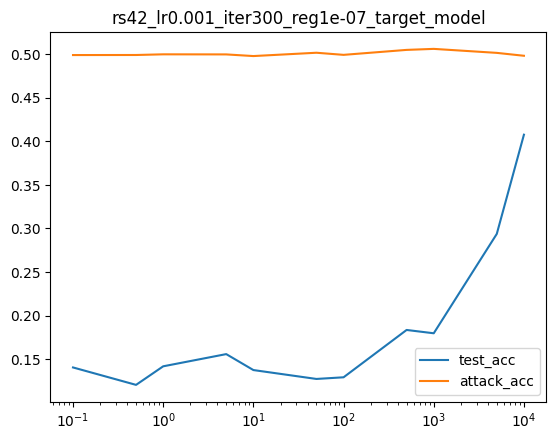

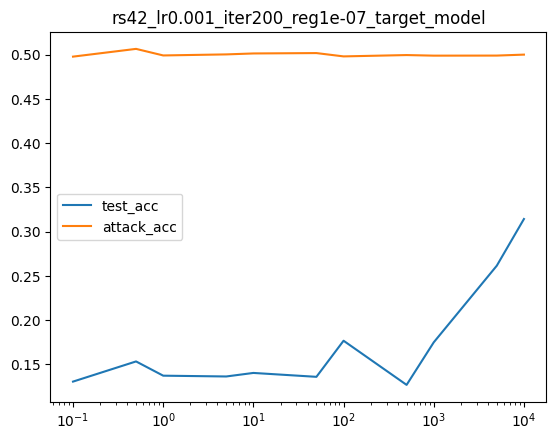

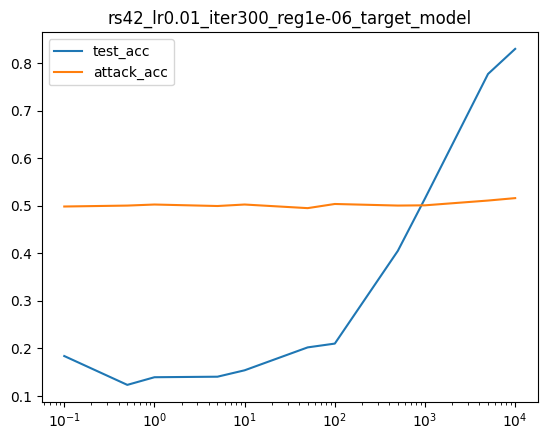

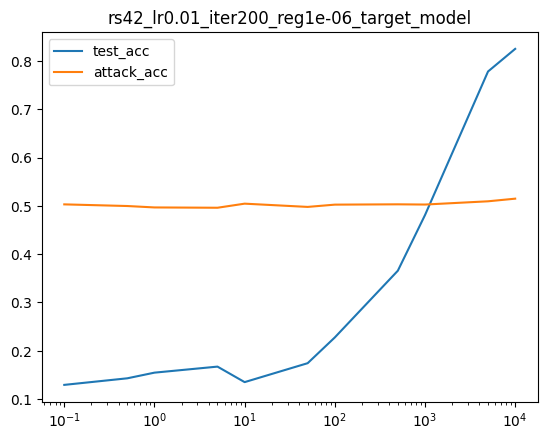

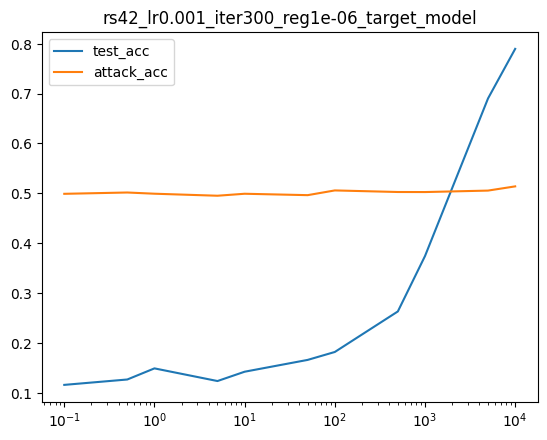

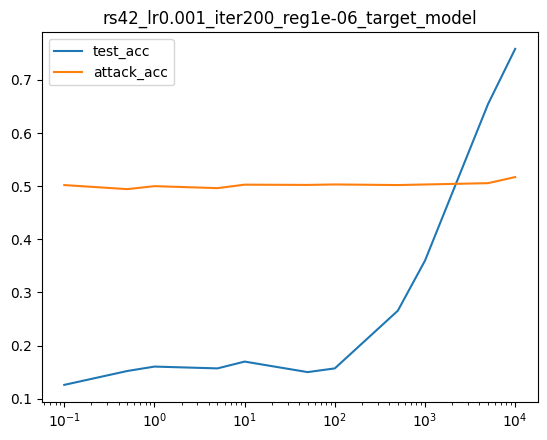

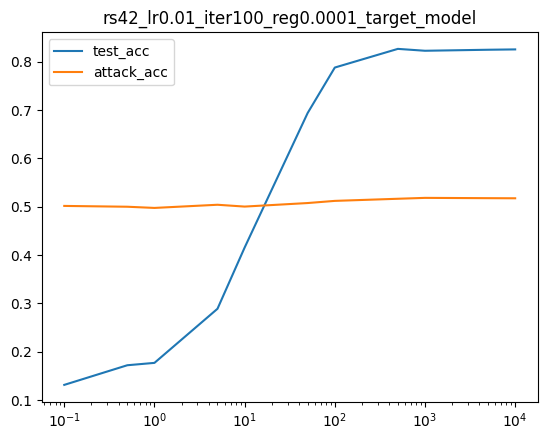

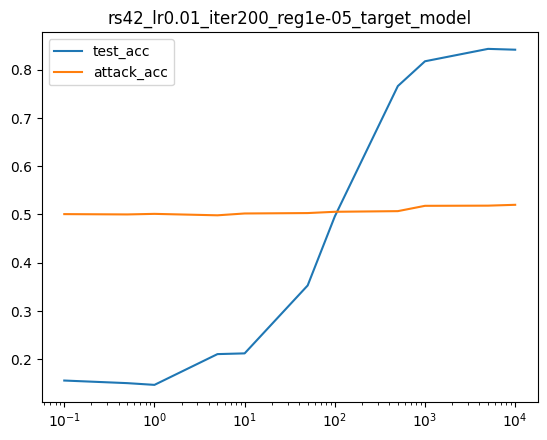

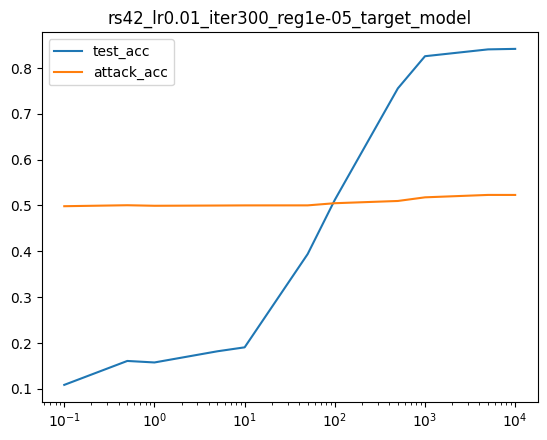

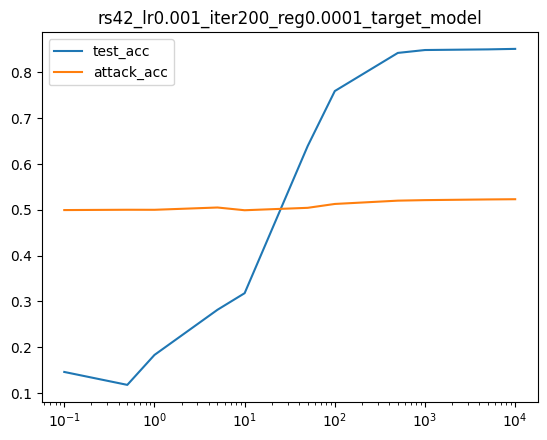

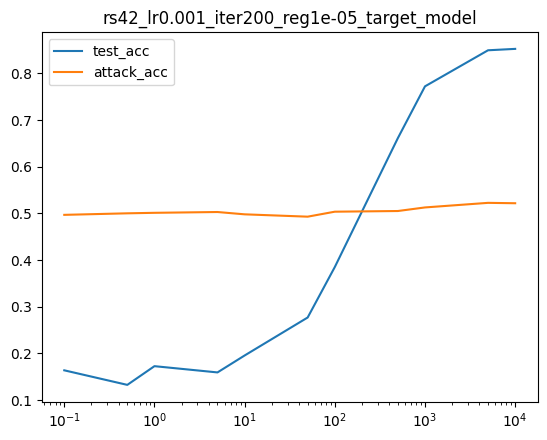

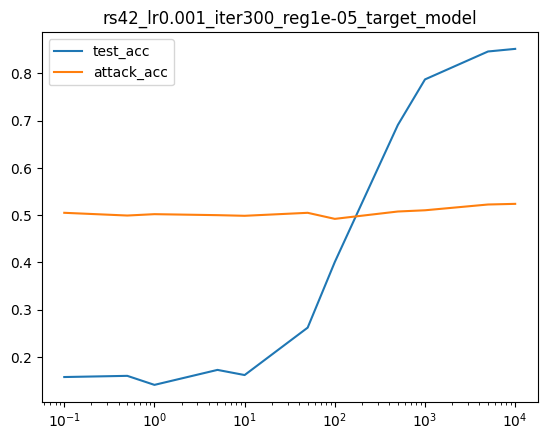

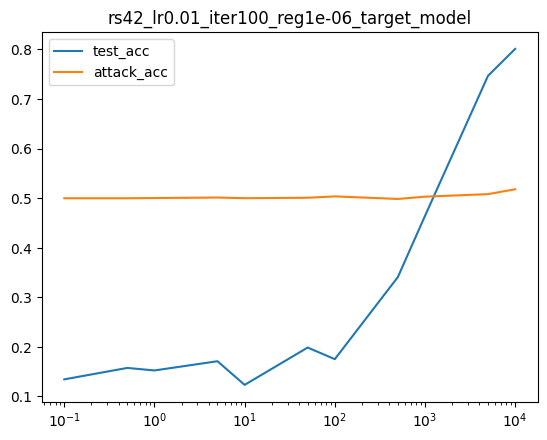

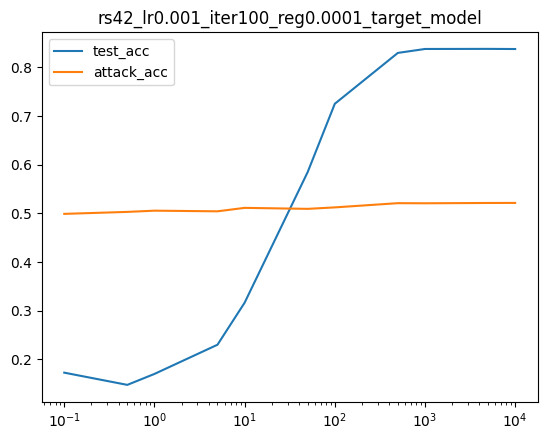

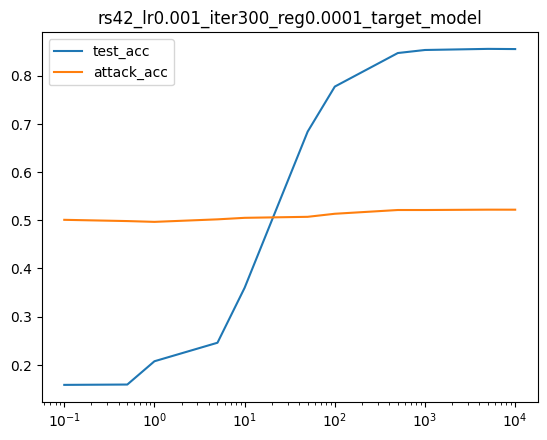

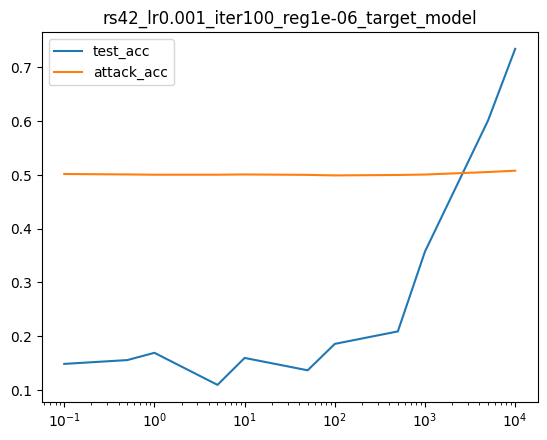

In [182]:
for mod in outdp:
    plt.figure()
    plt.title(mod)
    plt.plot(outdp[mod]['epsilon_out'], outdp[mod]['test_acc'], label='test_acc')
    plt.plot(outdp[mod]['epsilon_out'], outdp[mod]['attack_acc_mean'], label='attack_acc')
    plt.xscale('log')
    plt.legend()

In [184]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import algo
import scripts
# import attack

import torch
import os
import json

rand_seed=42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

dataset = 'loan'
# x_target_train, y_target_train, x_target_test, y_target_test = scripts.load_purchase(rand_seed)
x_target_train, y_target_train, x_target_test, y_target_test = scripts.load_loan(rand_seed, tr_size=10000)
#x_target_train, y_target_train, x_target_test, y_target_test = scripts.load_texas()
tr_size = 1000
x_target_train = x_target_train[:tr_size]
y_target_train = y_target_train[:tr_size]
x_target_test = x_target_test[:tr_size]
y_target_test = y_target_test[:tr_size]


In [189]:
res = {}
for lam in [1e-6, 1e-4]:

    np.random.seed(rand_seed)
    torch.manual_seed(rand_seed)
    
    #for epsilon in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,5,10,30,50,70,100]:
    
    #for C in [1,1.5,2,3,4,5]:
    for C in [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        model = algo.LogisticRegression_DPSGD()

        model.n_classes      = len(np.unique(y_target_train))
        model.alpha          = 0.01
        model.max_iter       = 300
        model.lambda_        = lam
        model.tolerance      = 1e-5
        model.sgdDP          = True
        model.L              = 20 #should be 1 if DP == False
        model.epsilon        = 10000
        model.C              = C
        model.outDP_local          = False
        model.outDP_local_epsilon  = 1

        params = dict(model.__dict__) #save model's parameters to json file later

        print("Start training")
        print(f'c: {C}; lam: {lam}')
        tm_path = f'small_loan/c{C}_lam{lam}'
        X,y = model.init_theta(x_target_train, y_target_train)
        model.train(X,y)
        params['train_acc'] = model.evaluate(x_target_train, y_target_train, acc=True)
        params['test_acc'] = model.evaluate(x_target_test, y_target_test, acc=True)

        if model.outDP_local:
            noise_model = scripts.output_DP(model,  x_target_train.shape[0], model.outDP_local_epsilon)
            params['train_acc_output_dp'] = noise_model.evaluate(x_target_train, y_target_train, acc=True)
            params['test_acc_output_dp'] = noise_model.evaluate(x_target_test, y_target_test, acc=True)
        
        attack_dict = attack.test_mi_attack(ams, model, x_target_train, y_target_train, x_target_test, y_target_test)
        params.update(attack_dict)
    
        np.save(tm_path+'_target_model', model.theta)
        with open(tm_path+'_target_model_params.json', 'w') as file:
            json.dump(params, file)

           


Start training
c: 1; lam: 1e-06
DP-SGD with sampling rate = 2% and noise_multiplier = 0.2176172972207593 iterated over 15000 steps satisfies differential privacy with eps = 1e+04 and delta = 1e-05.
The accuracy of the model : 65.60000000000001 %
The accuracy of the model : 45.800000000000004 %
Start training
c: 1.5; lam: 1e-06
DP-SGD with sampling rate = 2% and noise_multiplier = 0.2176172972207593 iterated over 15000 steps satisfies differential privacy with eps = 1e+04 and delta = 1e-05.
The accuracy of the model : 69.19999999999999 %
The accuracy of the model : 47.699999999999996 %
Start training
c: 2; lam: 1e-06
DP-SGD with sampling rate = 2% and noise_multiplier = 0.2176172972207593 iterated over 15000 steps satisfies differential privacy with eps = 1e+04 and delta = 1e-05.
The accuracy of the model : 71.2 %
The accuracy of the model : 49.3 %
Start training
c: 3; lam: 1e-06
DP-SGD with sampling rate = 2% and noise_multiplier = 0.2176172972207593 iterated over 15000 steps satisfies

In [194]:
path = 'small_loan/'
params = {}
results = {}
models = {}
for r,d,f in os.walk(path):
    for file in f:
        if "params.json" in file:
            with open(r+'/'+file) as json_file:
                params[file] = json.load(json_file)


In [195]:
params

{'c3_lam0.0001_target_model_params.json': {'n_classes': 7,
  'alpha': 0.01,
  'max_iter': 300,
  'lambda_': 0.0001,
  'tolerance': 1e-05,
  'sgdDP': True,
  'L': 20,
  'C': 3,
  'epsilon': 10000,
  'delta': 1e-05,
  'sigma': 0,
  'outDP_local': False,
  'outDP_local_epsilon': 1,
  'train_acc': 0.766,
  'test_acc': 0.527,
  'attack_acc_mean': 0.6269166666666667,
  'attack_acc_std': 0.0022806553639006756,
  'attack_pre_mean': 0.6035853962110685,
  'attack_pre_std': 0.01342545166715442,
  'attack_rec_mean': 0.7468333333333333,
  'attack_rec_std': 0.054038309456244916},
 'c8_lam0.0001_target_model_params.json': {'n_classes': 7,
  'alpha': 0.01,
  'max_iter': 300,
  'lambda_': 0.0001,
  'tolerance': 1e-05,
  'sgdDP': True,
  'L': 20,
  'C': 8,
  'epsilon': 10000,
  'delta': 1e-05,
  'sigma': 0,
  'outDP_local': False,
  'outDP_local_epsilon': 1,
  'train_acc': 0.871,
  'test_acc': 0.602,
  'attack_acc_mean': 0.6410833333333333,
  'attack_acc_std': 0.007446568934005015,
  'attack_pre_mean': 

In [196]:
df = pd.DataFrame.from_dict(params, orient='index')
# df = df.loc[df['max_iter']==100].loc[df['n_classes']==100].loc[df['alpha']==0.001].loc[df['lambda_']==0.00001].loc[df['tolerance']==0.00001].loc[df['C']==1].loc[df['delta']==0.00001]        
df.shape

(22, 21)

In [204]:
df

,n_classes,alpha,max_iter,lambda_,tolerance,sgdDP,L,C,epsilon,delta,...,outDP_local,outDP_local_epsilon,train_acc,test_acc,attack_acc_mean,attack_acc_std,attack_pre_mean,attack_pre_std,attack_rec_mean,attack_rec_std
c3_lam0.0001_target_model_params.json,7,0.01,300,0.000100,0.00001,True,20,3.0,10000,0.00001,...,False,1,0.766,0.527,0.626917,0.002281,0.603585,0.013425,0.746833,0.054038
c8_lam0.0001_target_model_params.json,7,0.01,300,0.000100,0.00001,True,20,8.0,10000,0.00001,...,False,1,0.871,0.602,0.641083,0.007447,0.602701,0.007474,0.833500,0.083853
c2_lam1e-06_target_model_params.json,7,0.01,300,0.000001,0.00001,True,20,2.0,10000,0.00001,...,False,1,0.712,0.493,0.619000,0.001848,0.605170,0.011870,0.690000,0.044721
c5_lam0.0001_target_model_params.json,7,0.01,300,0.000100,0.00001,True,20,5.0,10000,0.00001,...,False,1,0.825,0.566,0.636667,0.002981,0.604008,0.008961,0.799000,0.064846
c10_lam0.0001_target_model_params.json,7,0.01,300,0.000100,0.00001,True,20,10.0,10000,0.00001,...,False,1,0.870,0.599,0.637333,0.006039,0.600292,0.007505,0.827333,0.077517
c1.5_lam1e-06_target_model_params.json,7,0.01,300,0.000001,0.00001,True,20,1.5,10000,0.00001,...,False,1,0.692,0.477,0.613333,0.002867,0.605312,0.007915,0.655000,0.050537
c2_lam0.0001_target_model_params.json,7,0.01,300,0.000100,0.00001,True,20,2.0,10000,0.00001,...,False,1,0.719,0.503,0.620750,0.000629,0.605450,0.010934,0.698667,0.052175
c3_lam1e-06_target_model_params.json,7,0.01,300,0.000001,0.00001,True,20,3.0,10000,0.00001,...,False,1,0.768,0.521,0.631583,0.002009,0.608081,0.013607,0.747333,0.053817
c9_lam0.0001_target_model_params.json,7,0.01,300,0.000100,0.00001,True,20,9.0,10000,0.00001,...,False,1,0.878,0.591,0.645833,0.007760,0.606773,0.006111,0.832667,0.076330
c1_lam1e-06_target_model_params.json,7,0.01,300,0.000001,0.00001,True,20,1.0,10000,0.00001,...,False,1,0.656,0.458,0.604083,0.005877,0.604101,0.006050,0.607000,0.057692


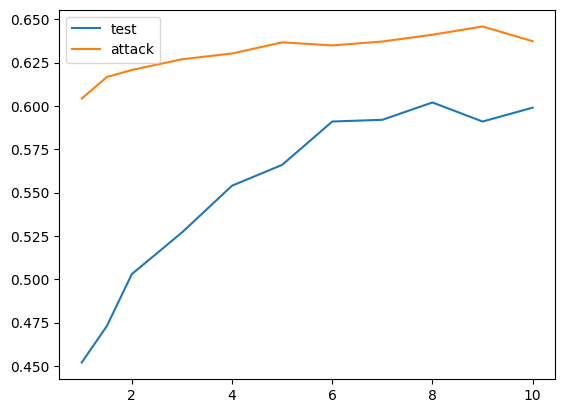

In [203]:
data = df.loc[df['lambda_']==0.0001].sort_values(by=['C'], ascending=False)
plt.plot(data['C'], data['test_acc'], label='test')
plt.plot(data['C'], data['attack_acc_mean'], label='attack')
plt.legend()

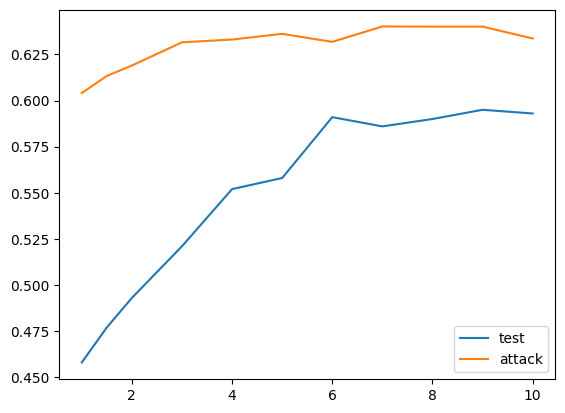

In [205]:

data = df.loc[df['lambda_']==0.000001].sort_values(by=['C'], ascending=False)
plt.plot(data['C'], data['test_acc'], label='test')
plt.plot(data['C'], data['attack_acc_mean'], label='attack')
plt.legend()